<a href="https://colab.research.google.com/github/Splaash/fashion_mnist/blob/main/detect_anomalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 144s 286ms/step - loss: 0.1188 - val_loss: 0.1120
Epoch 2/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 136s 275ms/step - loss: 0.1121 - val_loss: 0.1120
Epoch 3/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 134s 272ms/step - loss: 0.1122 - val_loss: 0.1120
Epoch 4/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 148s 285ms/step - loss: 0.1124 - val_loss: 0.1120
Epoch 5/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 135s 274ms/step - loss: 0.1122 - val_loss: 0.1120
Epoch 6/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 134s 272ms/step - loss: 0.1123 - val_loss: 0.1120
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step
Тест на MNIST (ожидается: цифра)
Index (val): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


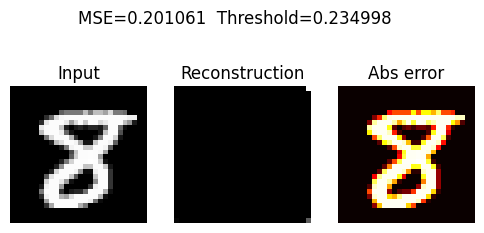

Изображение содержит рукописную цифру
----
Index (val): 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


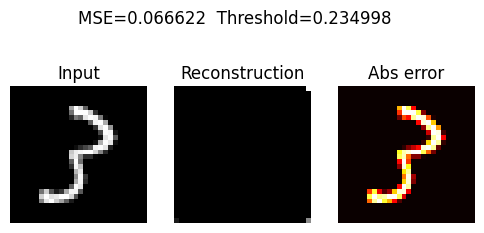

Изображение содержит рукописную цифру
----
Index (val): 42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


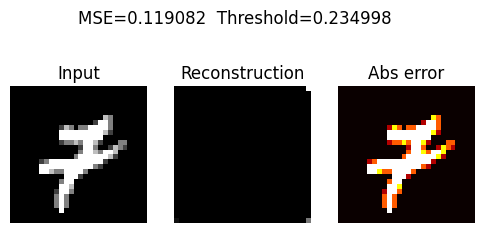

Изображение содержит рукописную цифру
----
Тест на Fashion-MNIST (ожидается: не цифра)
Fashion index: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


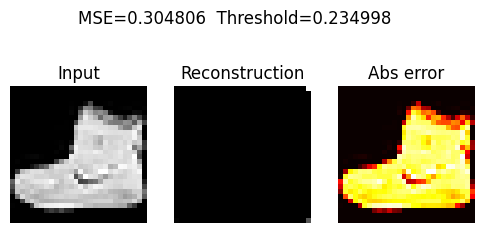

Изображение не содержит рукописной цифры
----
Fashion index: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


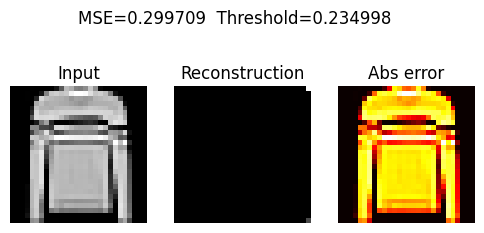

Изображение не содержит рукописной цифры
----
Fashion index: 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


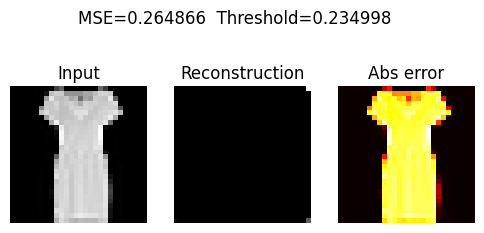

Изображение не содержит рукописной цифры
----


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Загрузка и подготовка данных
(x_train, _), (x_test_mnist, _) = mnist.load_data()
x = np.concatenate([x_train, x_test_mnist], axis=0)  # всё MNIST
x = x.astype('float32') / 255.0
x = np.expand_dims(x, -1)

x_train, x_val = train_test_split(x, test_size=0.1, random_state=42)

(x_f_train, _), (x_f_test, _) = fashion_mnist.load_data()
x_f = np.concatenate([x_f_train, x_f_test], axis=0).astype('float32') / 255.0
x_f = np.expand_dims(x_f, -1)

# Построение автокодировщика
input_shape = (28,28,1)
latent_dim = 16

encoder_input = layers.Input(shape=input_shape)
x_enc = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_input)
x_enc = layers.MaxPooling2D(2, padding='same')(x_enc)
x_enc = layers.Conv2D(64, 3, activation='relu', padding='same')(x_enc)
x_enc = layers.MaxPooling2D(2, padding='same')(x_enc)
x_enc = layers.Flatten()(x_enc)
latent = layers.Dense(latent_dim)(x_enc)

encoder = models.Model(encoder_input, latent, name='encoder')

decoder_input = layers.Input(shape=(latent_dim,))
x_dec = layers.Dense(7*7*64, activation='relu')(decoder_input)
x_dec = layers.Reshape((7,7,64))(x_dec)
x_dec = layers.Conv2DTranspose(64, 3, strides=1, activation='relu', padding='same')(x_dec)
x_dec = layers.UpSampling2D(2)(x_dec)
x_dec = layers.Conv2DTranspose(32, 3, strides=1, activation='relu', padding='same')(x_dec)
x_dec = layers.UpSampling2D(2)(x_dec)
x_dec = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x_dec)

decoder = models.Model(decoder_input, x_dec, name='decoder')

autoencoder_input = encoder_input
autoencoder_latent = encoder(autoencoder_input)
autoencoder_output = decoder(autoencoder_latent)
autoencoder = models.Model(autoencoder_input, autoencoder_output, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')

# Обучение автокодировщика
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_val, x_val),
    callbacks=[es]
)

# Вычисление порога аномалии
recon_val = autoencoder.predict(x_val)
mse_val = np.mean(np.square(x_val - recon_val), axis=(1,2,3))
mean_mse = mse_val.mean()
std_mse = mse_val.std()
threshold = mean_mse + 3 * std_mse

# Функции для детекции аномалий
def reconstruction_error(img):
    img = img.astype('float32')
    if img.ndim == 3:
        img_in = np.expand_dims(img, 0)
    else:
        img_in = img
    recon = autoencoder.predict(img_in)
    mse = np.mean(np.square(img_in - recon), axis=(1,2,3))
    return mse[0], recon[0]

def detect_and_print(img, threshold=threshold, show_fig=True):
    mse, recon = reconstruction_error(img)
    if show_fig:
        plt.figure(figsize=(6,3))
        plt.subplot(1,3,1)
        plt.title("Input")
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.title("Reconstruction")
        plt.imshow(recon.squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.title("Abs error")
        plt.imshow(np.abs(img.squeeze() - recon.squeeze()), cmap='hot')
        plt.axis('off')
        plt.suptitle(f"MSE={mse:.6f}  Threshold={threshold:.6f}")
        plt.show()

    if mse > threshold:
        print("Изображение не содержит рукописной цифры")
    else:
        print("Изображение содержит рукописную цифру")
    return mse

# Тестирование на MNIST
print("Тест на MNIST (ожидается: цифра)")
for i in [0, 10, 42]:
    idx = i
    img = x_val[idx]
    print("Index (val):", idx)
    detect_and_print(img)
    print("----")

# Тестирование на Fashion MNIST
print("Тест на Fashion-MNIST (ожидается: не цифра)")
for i in [0, 5, 20]:
    img = x_f[i]
    print("Fashion index:", i)
    detect_and_print(img)
    print("----")
